# Machine Failure Classification

## Objective

Predict whether the machine will fail or not, also predict the type of failure. So we are dealing with two predictions machine failure (binary) and type (multiclass)

## About the dataset

The dataset consists of 10 000 data points stored as rows with 14 features in columns

<li>UID: unique identifier ranging from 1 to 10000
<li>productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
<li>air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
<li>process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
<li>rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
<li>torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
<li>tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

## Importing libraries

In [123]:
#Data handling
import pandas as pd
import numpy as np

#Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.tree import plot_tree 

#Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold


#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

#Misc
import os 
import math

## Reading the dataset

In [2]:
INPUT_PATH = '/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv'
df = pd.read_csv(INPUT_PATH)
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

## EDA

In [3]:
def summ(df):
    print(f"Shape : {df.shape}")
    summ = pd.DataFrame(df.dtypes, columns = ['data_type'])
    summ['#missing'] = df.isna().sum().values
    summ['%missing'] = df.isna().sum().values/ len(df)
    summ['#unique'] = df.nunique().values
    
    desc = pd.DataFrame(df.describe(include = 'all').transpose())
    summ['min'] = desc['min']
    summ['max'] = desc['max']
    summ['mean'] = desc['mean']
    
    summ['first_value'] = df.iloc[0]
    summ['second_value'] = df.iloc[1]
    summ['third_value'] = df.iloc[2]
    
    return summ

In [4]:
summ(df)

Shape : (10000, 10)


data_type  #missing  %missing  #unique     min  \
UDI                         int64         0       0.0    10000     1.0   
Product ID                 object         0       0.0    10000     NaN   
Type                       object         0       0.0        3     NaN   
Air temperature [K]       float64         0       0.0       93   295.3   
Process temperature [K]   float64         0       0.0       82   305.7   
Rotational speed [rpm]      int64         0       0.0      941  1168.0   
Torque [Nm]               float64         0       0.0      577     3.8   
Tool wear [min]             int64         0       0.0      246     0.0   
Target                      int64         0       0.0        2     0.0   
Failure Type               object         0       0.0        6     NaN   

                             max       mean first_value second_value  \
UDI                      10000.0     5000.5           1            2   
Product ID                   NaN        NaN      M14860       L47181   
Type                         NaN        NaN           M            L   
Air temperature [K]        304.5  300.00493       298.1        298.2   
Process temperature [K]    313.8  310.00556       308.6        308.7   
Rotational speed [rpm]    2886.0  1538.7761        1551         1408   
Torque [Nm]                 76.6   39.98691        42.8         46.3   
Tool wear [min]            253.0    107.951           0            3   
Target                       1.0     0.0339           0            0   
Failure Type                 NaN        NaN  No Failure   No Failure   

                        third_value  
UDI                               3  
Product ID                   L47182  
Type                              L  
Air temperature [K]           298.1  
Process temperature [K]       308.5  
Rotational speed [rpm]         1498  
Torque [Nm]                    49.4  
Tool wear [min]                   5  
Target                            0  
Failure Type             No Failure

Initial Observations:
<li> We won't be needing UDI and Product ID since it is different for every row
<li> There are six types of failure show in the Failure Type column
<li> We can extract product type from Product ID column but it is already extracted in the Type column

In [5]:
targets = ['Target', 'Failure Type']
features = [feature for feature in df.columns if feature not in targets]

Let's take a look at target distribution

In [6]:
px.histogram(df[targets[0]], color = df[targets[0]])

We a dealing with an imbalanced dataset, we only have 339 rows with failure

Let's look at the type of failures as well

In [7]:
px.histogram(df[targets[1]], color = df[targets[1]])

In [8]:
feature_df = df[features].drop(['UDI', 'Product ID'], axis = 1)

In [9]:
feature_df

Type  Air temperature [K]  Process temperature [K]  \
0       M                298.1                    308.6   
1       L                298.2                    308.7   
2       L                298.1                    308.5   
3       L                298.2                    308.6   
4       L                298.2                    308.7   
...   ...                  ...                      ...   
9995    M                298.8                    308.4   
9996    H                298.9                    308.4   
9997    M                299.0                    308.6   
9998    H                299.0                    308.7   
9999    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
0                       1551         42.8                0  
1                       1408         46.3                3  
2                       1498         49.4                5  
3                       1433         39.5                7  
4                       1408         40.0                9  
...                      ...          ...              ...  
9995                    1604         29.5               14  
9996                    1632         31.8               17  
9997                    1645         33.4               22  
9998                    1408         48.5               25  
9999                    1500         40.2               30  

[10000 rows x 6 columns]

We have 1 categorical column and 5 numeric columns

Let's do a correlation analysis to see if there is any correlation among the variables

In [10]:
corr = feature_df.corr()
fig = px.imshow(corr, text_auto = True)
fig.update_layout(
    height = 800,
    width = 800
)

/tmp/ipykernel_186/618147364.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Initial observations:
<li>There is very high positive correlation between Process temperature and Air temperature
<li>There is very high negative correlation between Rotational speed and Torque

Let's try PCA to see if we can separate failure and non failure instances

In [11]:
feature_without_cat = feature_df.drop('Type', axis = 1)

In [12]:
#Scaling the features
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(feature_without_cat)

#PCA
pca = PCA(n_components = 2)
pca_df = pd.DataFrame(pca.fit_transform(feature_scaled), columns = ['PC1', 'PC2'])
print(f"Explained variance : {np.cumsum(pca.explained_variance_ratio_)[-1]}")

Explained variance : 0.7503185814368967


In [13]:
px.scatter(pca_df, x = 'PC1', y = 'PC2', color = df[targets[0]])

In [14]:
#Scaling the features
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(feature_without_cat)

#PCA
pca = PCA(n_components = 3)
pca_df = pd.DataFrame(pca.fit_transform(feature_scaled), columns = ['PC1', 'PC2', 'PC3'])
print(f"Explained variance : {np.cumsum(pca.explained_variance_ratio_)[-1]}")

Explained variance : 0.9502338403508379


In [15]:
px.scatter_3d(pca_df, x = 'PC1', y = 'PC2', z = 'PC3', color = df[targets[0]])

The dataset doesn't seems to be linearly separable

In [16]:
feature_with_cat = feature_df.copy()
feature_with_cat['enc_type'] = [0 if enc == 'L' else 1 if enc == 'M' else 3 for enc in feature_with_cat['Type']]
feature_with_cat['enc_type'] = feature_with_cat['enc_type'].astype(np.int16)
feature_with_cat.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  enc_type  
0         42.8                0         1  
1         46.3                3         0  
2         49.4                5         0  
3         39.5                7         0  
4         40.0                9         0

In [17]:
feature_with_cat.drop('Type', axis = 1, inplace = True)

In [18]:
feature_with_cat.dtypes

Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
enc_type                     int16
dtype: object

In [19]:
#Scaling the features
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(feature_with_cat)

#PCA
pca = PCA(n_components = 2)
pca_df = pd.DataFrame(pca.fit_transform(feature_scaled), columns = ['PC1', 'PC2'])
print(f"Explained variance : {np.cumsum(pca.explained_variance_ratio_)[-1]}")

Explained variance : 0.6253730555578563


In [20]:
px.scatter(pca_df, x = 'PC1', y = 'PC2', color = df[targets[0]])

In [21]:
#Scaling the features
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(feature_with_cat)

#PCA
pca = PCA(n_components = 3)
pca_df = pd.DataFrame(pca.fit_transform(feature_scaled), columns = ['PC1', 'PC2', 'PC3'])
print(f"Explained variance : {np.cumsum(pca.explained_variance_ratio_)[-1]}")

Explained variance : 0.7929018177356908


In [22]:
px.scatter_3d(pca_df, x = 'PC1', y = 'PC2', z = 'PC3', color = df[targets[0]])

Let's also take a look at the distribution of variables

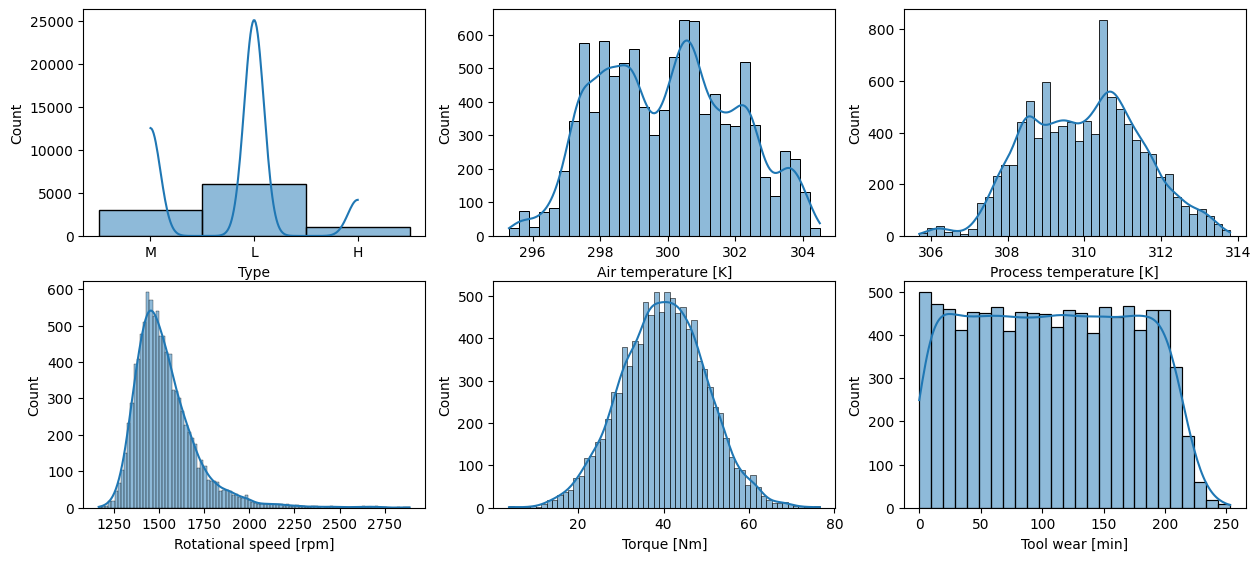

In [23]:
plt.figure(figsize=(15,10))
for i,col in enumerate(feature_df.columns,1):
    plt.subplot(3,3,i)
    sns.histplot(feature_df[col],kde=True)

In [24]:
feature_with_cat = pd.get_dummies(feature_df, drop_first = True)

In [25]:
#Scaling the features
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(feature_with_cat)

#PCA
pca = PCA(n_components = 2)
pca_df = pd.DataFrame(pca.fit_transform(feature_scaled), columns = ['PC1', 'PC2'])
print(f"Explained variance : {np.cumsum(pca.explained_variance_ratio_)[-1]}")

Explained variance : 0.5360229636309055


In [26]:
px.scatter(pca_df, x = 'PC1', y = 'PC2', color = df[targets[0]])

In [27]:
#Scaling the features
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(feature_with_cat)

#PCA
pca = PCA(n_components = 3)
pca_df = pd.DataFrame(pca.fit_transform(feature_scaled), columns = ['PC1', 'PC2', 'PC3'])
print(f"Explained variance : {np.cumsum(pca.explained_variance_ratio_)[-1]}")

Explained variance : 0.7932944857080346


In [35]:
px.scatter_3d(pca_df, x = 'PC1', y = 'PC2', z = 'PC3', color = df[targets[0]])

We should use the type feature

In [36]:
df[targets]

Target Failure Type
0          0   No Failure
1          0   No Failure
2          0   No Failure
3          0   No Failure
4          0   No Failure
...      ...          ...
9995       0   No Failure
9996       0   No Failure
9997       0   No Failure
9998       0   No Failure
9999       0   No Failure

[10000 rows x 2 columns]

We can just use the failure type column to detemine whether there is a failure or not, we don't need the Target column

Since we have a class imbalance problem, we should look at a few methods to handle it. We will be using oversampling in our case

In [62]:
X = pd.get_dummies(df[features].drop(['UDI', 'Product ID'], axis = 1), drop_first = True)
y = df[targets[1]]

## Oversampling

In [63]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [70]:
X

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0               298.100000               308.600000                    1551   
1               298.200000               308.700000                    1408   
2               298.100000               308.500000                    1498   
3               298.200000               308.600000                    1433   
4               298.200000               308.700000                    1408   
...                    ...                      ...                     ...   
57907           300.248262               309.738610                    1400   
57908           300.300000               311.157839                    1380   
57909           300.501187               310.281314                    1490   
57910           300.504621               310.155795                    1623   
57911           299.823091               309.414299                    1399   

       Torque [Nm]  Tool wear [min]  Type_L  Type_M  
0        42.800000                0       0       1  
1        46.300000                3       1       0  
2        49.400000                5       1       0  
3        39.500000                7       1       0  
4        40.000000                9       1       0  
...            ...              ...     ...     ...  
57907    43.133590              217       0       0  
57908    47.538559              218       0       0  
57909    38.174110              208       1       0  
57910    34.795354              223       0       0  
57911    42.078775              220       0       1  

[57912 rows x 7 columns]

In [64]:
y

0               No Failure
1               No Failure
2               No Failure
3               No Failure
4               No Failure
               ...        
57907    Tool Wear Failure
57908    Tool Wear Failure
57909    Tool Wear Failure
57910    Tool Wear Failure
57911    Tool Wear Failure
Name: Failure Type, Length: 57912, dtype: object

In [65]:
le = LabelEncoder()
y = le.fit_transform(y)

In [67]:
y

array([1, 1, 1, ..., 5, 5, 5])

In [66]:
X.shape, y.shape

((57912, 7), (57912,))

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [77]:
numeric_col = [col for col in X.columns if col not in ['Type_L', 'Type_M']]
categorical_col = [col for col in X.columns if col not in numeric_col]

In [153]:
def test_models(X_train, X_test, y_train, y_test):
    
    #Scaling numeric variables
    scaler = StandardScaler()
#     col_transform = ColumnTransformer([
#         ("scaler", scaler, numeric_col)
#     ], remainder='passthrough')
#     X_train = col_transform.fit_transform(X_train)
    
    #Logistic Regression
    lr = LogisticRegression(solver = 'sag')
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    print("-"*12,'Logistic Regression','-'*12)
    print(f"Accuracy on test data : {accuracy_score(y_test, y_pred_lr)}")
    print(f"F1-Score on test data : {f1_score(y_test, y_pred_lr, average = 'macro')}")
    print(f"ROC AUC on test data : {roc_auc_score(y_test, lr.predict_proba(X_test), average = 'macro', multi_class = 'ovo')}")
    
    #Decision Tree
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    print("-"*12,'Decision Tree','-'*12)
    print(f"Accuracy on test data : {accuracy_score(y_test, y_pred_dt)}")
    print(f"F1-Score on test data : {f1_score(y_test, y_pred_dt, average = 'macro')}")
    print(f"ROC AUC on test data : {roc_auc_score(y_test, dt.predict_proba(X_test), average = 'macro', multi_class = 'ovo')}")
    
    #SVC
    svc = SVC(kernel='rbf', probability = True)
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    print("-"*12,'Support Vector Classifier','-'*12)
    print(f"Accuracy on test data : {accuracy_score(y_test, y_pred_svc)}")
    print(f"F1-Score on test data : {f1_score(y_test, y_pred_svc, average = 'macro')}")
    print(f"ROC AUC on test data : {roc_auc_score(y_test, svc.predict_proba(X_test), average = 'macro', multi_class = 'ovo')}")
    

In [154]:
test_models(X_train, X_test, y_train, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



------------ Logistic Regression ------------
Accuracy on test data : 0.8099458961666859
F1-Score on test data : 0.8028187726727308
ROC AUC on test data : 0.9589347415735506
------------ Decision Tree ------------
Accuracy on test data : 0.9895245769540693
F1-Score on test data : 0.9895270127367235
ROC AUC on test data : 0.9937559330609905
------------ Support Vector Classifier ------------
Accuracy on test data : 0.6905721192586624
F1-Score on test data : 0.6840331395659481
ROC AUC on test data : 0.9405262185974124


In [155]:
#Using the decision tree classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(accuracy_score(y_test, y_pred_dt))
print(f1_score(y_test, y_pred_dt, average = 'macro'))
print(roc_auc_score(y_test, dt.predict_proba(X_test), average = 'macro', multi_class = 'ovo'))

0.9886036606423392
0.988610904636187
0.9932036072577868


In [158]:
 le.classes_

array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure'],
      dtype=object)

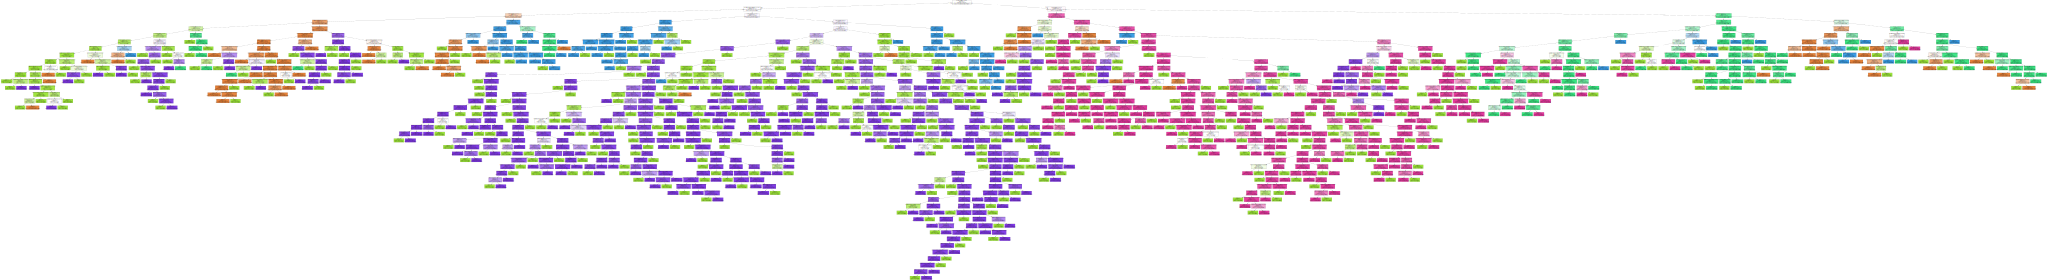

In [159]:
import graphviz
from sklearn import tree
# DOT data
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names= le.classes_,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph